# Transfer Learning and Drop-out

In [1]:
import os, zipfile
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Getting the pretrained model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-09-18 03:48:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.176, 2a00:1450:4017:800::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  3.80MB/s    in 22s     

2019-09-18 03:48:25 (3.86 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Using pretrained model

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
pre_trained_model.load_weights(local_weights_file)

In [7]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Creating DNN with pretrained model

In [9]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

In [10]:
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Cats and dogs classifier using new model

In [10]:
# Getting the small dataset
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2019-09-18 03:52:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.176, 2a00:1450:4017:800::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  3.91MB/s    in 17s     

2019-09-18 03:52:58 (3.77 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [11]:
# Unzipping the dataset
local_zip = '//tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

In [12]:
train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

In [13]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [14]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(
                generator = train_generator,
                validation_data = validation_generator,
                steps_per_epoch = 100,
                epochs = 20,
                validation_steps = 50,
                verbose = 2)

Epoch 1/20
100/100 - 22s - loss: 0.5345 - acc: 0.7430 - val_loss: 0.1739 - val_acc: 0.9390
Epoch 2/20
100/100 - 17s - loss: 0.3566 - acc: 0.8325 - val_loss: 0.3857 - val_acc: 0.9120
Epoch 3/20
100/100 - 18s - loss: 0.3533 - acc: 0.8460 - val_loss: 0.3958 - val_acc: 0.9230
Epoch 4/20
100/100 - 19s - loss: 0.3323 - acc: 0.8585 - val_loss: 0.2064 - val_acc: 0.9580
Epoch 5/20
100/100 - 18s - loss: 0.3421 - acc: 0.8600 - val_loss: 0.3229 - val_acc: 0.9380
Epoch 6/20
100/100 - 19s - loss: 0.2957 - acc: 0.8750 - val_loss: 0.5952 - val_acc: 0.9190
Epoch 7/20
100/100 - 18s - loss: 0.3155 - acc: 0.8720 - val_loss: 0.2585 - val_acc: 0.9530
Epoch 8/20
100/100 - 17s - loss: 0.2846 - acc: 0.8820 - val_loss: 0.5851 - val_acc: 0.9280
Epoch 9/20
100/100 - 17s - loss: 0.2776 - acc: 0.8835 - val_loss: 0.4267 - val_acc: 0.9420
Epoch 10/20
100/100 - 18s - loss: 0.3176 - acc: 0.8715 - val_loss: 0.3171 - val_acc: 0.9450
Epoch 11/20
100/100 - 18s - loss: 0.2883 - acc: 0.8875 - val_loss: 0.3715 - val_acc: 0.94

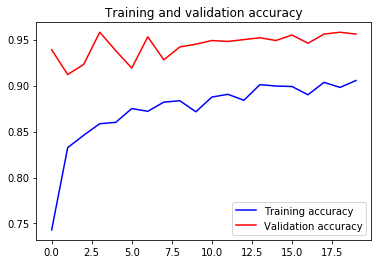

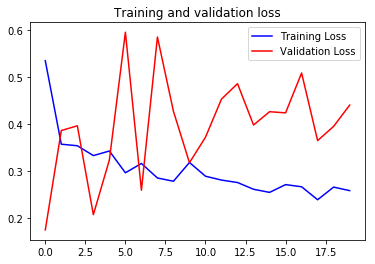

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()